In [11]:
import re
import os
import pathlib
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import gridspec
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set_theme(style="darkgrid")

# Root of the project
project_dir = pathlib.Path().resolve().parent

# Directory containing experiment results
results_dir = (pathlib.Path(project_dir) / "results").resolve()

# Directory for tidied data (output directory)
data_dir = (pathlib.Path(project_dir) / "data").resolve()

# Directory to store all plots
plot_dir = (pathlib.Path(project_dir) / "plots").resolve()



# Experiment constants
exp_name = "01_http_max_throughput"
file_prefix = "exp-01"

In [13]:
"""Load cleaned/aggregated data sets

resource_df -> CPU/Mem utilization for experiments
fortio_df -> Load test results from fortio
"""

resource_df = pd.read_feather(data_dir / "resource_results.feather")
# fortio_df = pd.read_feather(data_dir / "fortio_results.feather")

In [14]:
"""
Prepares the experiment data

"""

exp = resource_df[resource_df["experiment"] == exp_name]
exp.head()

,experiment,mesh,requested_qps,pod,container,cpu,mem,date
0,01_http_max_throughput,Baseline,MAX,target-fortio-746f85d498-tmrfm,fortio,0.000719,1072.776342,2022-06-26 14:31:58
1,01_http_max_throughput,Baseline,MAX,target-fortio-746f85d498-tmrfm,fortio,0.000719,1072.776342,2022-06-26 14:32:01
2,01_http_max_throughput,Baseline,MAX,target-fortio-746f85d498-tmrfm,fortio,0.049509,18820.872955,2022-06-26 14:32:04
3,01_http_max_throughput,Baseline,MAX,target-fortio-746f85d498-tmrfm,fortio,0.063200,24103.189715,2022-06-26 14:32:07
4,01_http_max_throughput,Baseline,MAX,target-fortio-746f85d498-tmrfm,fortio,0.063200,24103.189715,2022-06-26 14:32:10


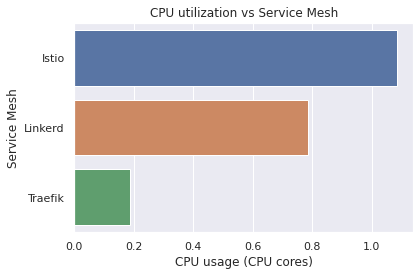

In [61]:
"""
PLOT: Boxplot CPU usage by mesh
Desc: 
"""

file_name = f"{file_prefix}-box_cpu.pdf"
plot_title = "CPU utilization vs Service Mesh"

fig, ax = plt.subplots()


data = exp[exp["container"] != "fortio"]
data = data[data["mesh"] != "Cilium"]
data = data.groupby(["mesh"]).mean().reset_index().sort_values(by="cpu", ascending=False)

ax = sns.barplot(data=data, x="cpu", y="mesh")

# Labels
ax.set_ylabel("Service Mesh")
ax.set_xlabel("CPU usage (CPU cores)")
ax.set_title(plot_title)

# ax.set_xscale("log")


fig.tight_layout()
# fig.savefig(plot_dir / file_name)

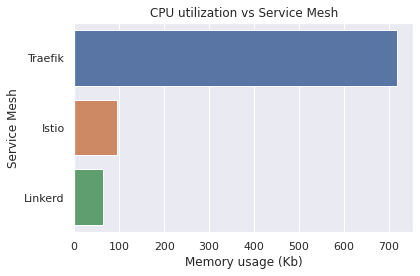

In [67]:
"""
PLOT: Boxplot CPU usage by mesh
Desc: 
"""

file_name = f"{file_prefix}-box_mem.pdf"
plot_title = "CPU utilization vs Service Mesh"

fig, ax = plt.subplots()


data = exp[exp["container"] != "fortio"]
data = data[data["mesh"] != "Cilium"]
data["mem"] /= 1000
data = data.groupby(["mesh"]).mean().reset_index().sort_values(by="mem", ascending=False)

ax = sns.barplot(data=data, x="mem", y="mesh")

# Labels
ax.set_ylabel("Service Mesh")
ax.set_xlabel("Memory usage (Kb)")
ax.set_title(plot_title)

# ax.set_xscale("log")


fig.tight_layout()
# fig.savefig(plot_dir / file_name)


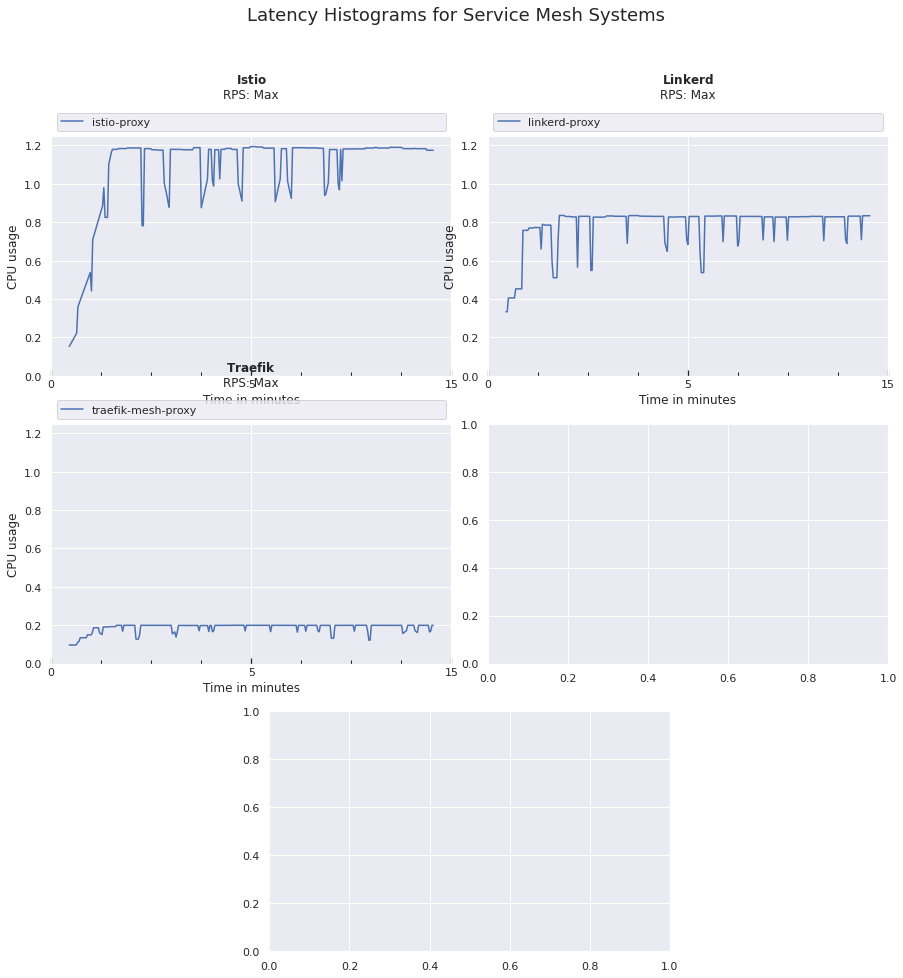

In [78]:

"""
PLOT: Histogram plots
Desc: 
"""

file_name = f"{file_prefix}-hist_latencies.pdf"


# Create grid of plots
fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(nrows=3, ncols=4)

# Create subplots, each plot is 2 cols wide
axes=[
    # Row 0
    fig.add_subplot(gs[0, 0:2]),
    fig.add_subplot(gs[0, 2:4]),
    # Row 1 
    fig.add_subplot(gs[1, 0:2]),
    fig.add_subplot(gs[1, 2:4]),
    # Row 2 (offset by 1)
    fig.add_subplot(gs[2, 1:3]),
]

# Set figure title
fig.suptitle("Latency Histograms for Service Mesh Systems", fontsize=18, y=1)

mesh_configs = ["Istio", "Linkerd", "Traefik"]

for i, m in enumerate(mesh_configs):

    ax = axes[i]
    data = exp[exp["mesh"] == m]
    data = data[data["container"] != "fortio"]

    # Calculate time deltas
    time_delta = data.date - data.date.min()

    sns.lineplot(data=data, x=time_delta, y="cpu", hue="container", ax=ax)

    mesh = data["mesh"].iloc[0].capitalize()
    qps = data["requested_qps"].iloc[0].capitalize()

    # Labels
    plot_title = f"$\\bf{mesh}$\n" f"RPS: {qps}\n"
    ax.set_ylabel("CPU usage")
    ax.set_xlabel("Time in minutes")
    ax.set_title(plot_title, y=1.07)

    # X axis configuration
    # Major tick -> Every 5 minutes
    # Minor tick -> Every minute
    ax.xaxis.set_major_locator(ticker.LinearLocator(numticks=3))
    ax.set_xticklabels([0, 5, 15])
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    ax.minorticks_on()
    ax.tick_params(axis="x", direction="in", which="both", bottom=True)

    # Y axis configuration
    ax.set_ylim(bottom=0, top=1.25)

    # Place legend above axes
    # ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.legend(
        bbox_to_anchor=(0, 0.92, 1, 0.2), mode="expand", ncol=2, loc="upper center"
    )


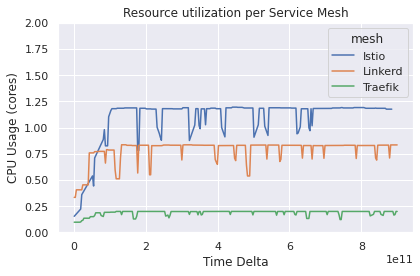

In [122]:
"""
PLOT: Boxplot CPU usage by mesh
Desc: 
"""

file_name = f"{file_prefix}-resource.pdf"
plot_title = "Resource utilization per Service Mesh"

fig, ax = plt.subplots()


data = exp[exp["container"] != "fortio"]
data = data[data["mesh"] != "Cilium"]

# Adds time delta per experiment
data["delta"] = data.sort_values(["mesh", "date"]).groupby("mesh")["date"].transform(lambda x: x - x.min())
data["mem"] /= 1000

sns.lineplot(data=data, x="delta", y="cpu", hue="mesh", ax=ax)

# Labels
ax.set_ylabel("CPU Usage (cores)")
ax.set_xlabel("Time Delta")
ax.set_title(plot_title)

ax.set_ylim(0, 2)

# ax.set_xscale("log")

# Second plot with cumulative density
# ax2 = ax.twinx()
# ax2.set_alpha(0.5)
# ax2.grid(False)
# sns.lineplot(data=data, x="delta", y="mem", hue="mesh", ax=ax)
# # ax2.get_legend().remove()

fig.tight_layout()
# fig.savefig(plot_dir / file_name)
